In [74]:
import numba as nb
import numpy as np
import matplotlib.pyplot as plt
import random as random

from seaborn import color_palette, set_palette
from matplotlib import rc, cm

plt.style.use('seaborn-white')
set_palette("deep")

rc('font', **{'family': 'serif', 'serif': ['Palatino']})
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{underscore}')

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

def impact_perm(nu, gamma, beta):
    """Returns the permenant dollar price impact per unit time
    In paper as :math:`g(\nu)`
    Args:
        nu: rate of trading :math:`\nu = n_k / \tau`.
        gamma: Const. the $ move per share traded
        beta: Const. power law scaling of nu for perm impact.
            Default is .5 for square root rule
    """
    return gamma * nu ** beta


def impact_temp(nu, eps, eta, alpha):
    """Returns the temporary dollar price impact
    In 2005 paper as :math:`h(\nu)`
    Args:
        nu: rate of trading :math:`\nu = n_k / \tau`.
        eps: Const. $ move
        eta: Const. the $ move per trading speed
        alpha: Const. power law scaling of nu for temp impact.
            Deafult if 1 for arbitrage free linear model
    """
    return eps * np.sign(nu) + eta * nu ** alpha


def is_expected(n_t, gamma, eta, eps, tau):
    """The expected implementation shortfall
    Args:
        n_t: array of units executed at each time step where
            ``len(n_t * tau)`` is the time taken to execute
        gamma: Const. the $ move per share traded
        eta: Const. the $ move per trading speed
        eps: Const. the $ move per share traded
        tau: Time step between each element of n_t
    """
    x_k = np.cumsum(n_t[::-1])  # units left to execute
    nu_t = n_t / tau
    return (
        np.sum(tau * x_k * impact_perm(nu_t, gamma, beta)) +
        np.sum(n_t * impact_temp(nu_t, eps, eta, alpha))
    )

def is_var(n_t, sigma, tau):
    """The vairance of the implementation shortfall
    Args:
        n_t: array of units executed at each time step where
            ``len(n_t * tau)`` is the time taken to execute
        sigma: The vol of underlying securities
        tau: Time step between each element of n_t
    """
    x_k = np.cumsum(n_t[::-1])  # units left to execute
    return sigma**2 + tau * np.dot(x_k.T, x_k)


def is_objective(n_t, risk_tol, gamma, eta, eps, tau, sigma):
    """Almgren-Chriss objective function
    Args:
        n_t: array of units executed at each time step where
            ``len(n_t * tau)`` is the time taken to execute
        gamma: Const. the $ move per share traded
        eta: Const. the $ move per trading speed
        eps: Const. the $ move per share traded
        tau: Time step between each element of n_t
    """

    return (is_expected(n_t, gamma, eta, eps, tau) +
            risk_tol*is_var(n_t, sigma, tau))


def trade_decay_rate(tau, risk_tol, sigma, eta, gamma):
    """Also known as :math:`\kappa` in the paper
    Note:
        :math:`\kappa^{-1}` is the time it takes to
        deplete the portfolio by a factor of :math:`e`
        If :math:`\lambda > 0` the trader will still liquidate the
        position on a time scale `:math:`\kappa^{-1}` so
        :math:`\kappa^{-1}` is the intrinsic time scale of the trade.
    Args:
        tau: Time step between each element of :math:`n_t`
        risk_tol: The risk tolerance
        sigma: volatility of the unit price
        eta: Const. the $ move per trading speed
        gamma: Const. the $ move per share traded
    """
    return np.sqrt(risk_tol*sigma**2 / (eta * (1 + .5*gamma*tau/eta)))
    


def trading_traj(trading_time, tau, risk_tol, sigma, eta, gamma):
    """Returns the optimal trading trajectory :math:`n_t`
    (allocates the distribution of units over tau)
    Args:
        trading_time: Total time to trade
        tau: Time step between each element of :math:`n_t`
        risk_tol: The risk tolerance
        sigma: volatility of the unit price
        eta: Const. the $ move per trading speed
        gamma: Const. the $ move per share traded
    """
    k = trade_decay_rate(tau, risk_tol, sigma, eta, gamma)
    tj = np.arange(trading_time/tau) * tau
    return 2*np.sinh(.5*k*tau)/np.sinh(k*trading_time)*np.cosh(k*tj*trading_time)

    
def trade_decay_rate_2(tau, risk_tol, sigma, eta, gamma):
    """Also known as :math:`\kappa` in the paper
    Note:
        :math:`\kappa^{-1}` is the time it takes to
        deplete the portfolio by a factor of :math:`e`
        If :math:`\lambda > 0` the trader will still liquidate the
        position on a time scale `:math:`\kappa^{-1}` so
        :math:`\kappa^{-1}` is the intrinsic time scale of the trade.
    Args:
        tau: Time step between each element of :math:`n_t`
        risk_tol: The risk tolerance
        sigma: volatility of the unit price
        eta: Const. the $ move per trading speed
        gamma: Const. the $ move per share traded
    """
    return np.sqrt(risk_tol*sigma**2/(eta*(1-gamma*tau/(2*eta))))
    

def trading_traj_2(trading_time, tau, risk_tol, sigma, eta, gamma,X):
    k = trade_decay_rate_2(tau, risk_tol, sigma, eta, gamma)
    tj = ((np.arange(1,trading_time))-.5)*tau

    if risk_tol == 0.0:
        ret = np.array([X*tau/trading_time] * trading_time)
    else:
        ret = 2*np.sinh(.5*k*tau)/np.sinh(k*trading_time)*np.cosh(k*(trading_time-tj))*X

        # Adjust the last period to ensure the sum is equal to X
        if np.sum(ret) != X:
            ret[-1] = X - np.sum(ret[:-1])
    return ret


C:\Users\jeope\AppData\Local\Temp\ipykernel_14112\1474149501.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


In [85]:
# Variables
X = 1e6
s_0 = 50.0
trading_time = 5

## Price evolution
gauss_mu, gauss_sigma = 0, 1
gauss_s = np.random.normal(gauss_mu, gauss_sigma, trading_time)/100
gauss_innovation = 1+gauss_s
_s0_gauss = 50*np.cumprod(gauss_innovation)
_s0_gauss = np.append(50,_s0_gauss)
_cs_gauss = 0.3/np.sqrt(250)
_sigma_gauss = [_cs_gauss * _s0_gauss]
_sigma_gauss = np.squeeze(_sigma_gauss)

t_s = np.random.standard_t(4, 5)/100
t_innovation = 1+t_s
_s0_t = 50*np.cumprod(t_innovation)
_s0_t = np.append(50,_s0_t)
_cs_t = 0.3/np.sqrt(250)
_sigma_t = [_cs_t * _s0_t]
_sigma_t = np.squeeze(_sigma_t)

## Parameters to compute implementation shortfall
alpha = 1
gamma = 2.5 * 10 ** (-7)
nu = 1
beta = 1
#####################################################
tau = 1
sigma_values = [0.3/np.sqrt(250)*s_0, _sigma_gauss[1:5], _sigma_t[1:5]] 
gamma = 2.5 * 10 ** (-7)
eta = 2.5 * 10 ** (-6)
eps = 1.0 / 16.0
risk_tol_values = [2 * 10 ** (-1), 2 * 10 ** (-2), 2 * 10 ** (-3), 2 * 10 ** (-4), 2 * 10 ** (-5),
                   2 * 10 ** (-6), 2 * 10 ** (-7), 2 * 10 ** (-8), 2 * 10 ** (-10), 0]

# Trading trajectories and paths
traj_test = []
path_test = []

for sigma in sigma_values:
    traj_sigma = []
    path_sigma = []
    for risk_tol in risk_tol_values:
        traj = trading_traj_2(trading_time=trading_time, tau=tau, risk_tol=risk_tol, sigma=sigma,
                              gamma=gamma, eta=eta, X=X)
        traj_sigma.append(traj)

        path = np.ones(1 + len(traj)) * X
        path[1:] -= np.cumsum(traj)
        path_sigma.append(path)

    traj_test.append(traj_sigma)
    path_test.append(path_sigma)

C:\Users\jeope\AppData\Local\Temp\ipykernel_14112\1474149501.py:148: RuntimeWarning: overflow encountered in sinh
  ret = 2*np.sinh(.5*k*tau)/np.sinh(k*trading_time)*np.cosh(k*(trading_time-tj))*X
C:\Users\jeope\AppData\Local\Temp\ipykernel_14112\1474149501.py:148: RuntimeWarning: overflow encountered in cosh
  ret = 2*np.sinh(.5*k*tau)/np.sinh(k*trading_time)*np.cosh(k*(trading_time-tj))*X
C:\Users\jeope\AppData\Local\Temp\ipykernel_14112\1474149501.py:148: RuntimeWarning: invalid value encountered in multiply
  ret = 2*np.sinh(.5*k*tau)/np.sinh(k*trading_time)*np.cosh(k*(trading_time-tj))*X


In [89]:
print(trade_decay_rate_2(tau,2*10**(-7),sigma,eta,gamma))
print(trade_decay_rate_2(tau,2*10**(-8),sigma,eta,gamma))


[0.28159432 0.28452014 0.28583769 0.28402124]
[0.08904794 0.08997317 0.09038982 0.0898154 ]


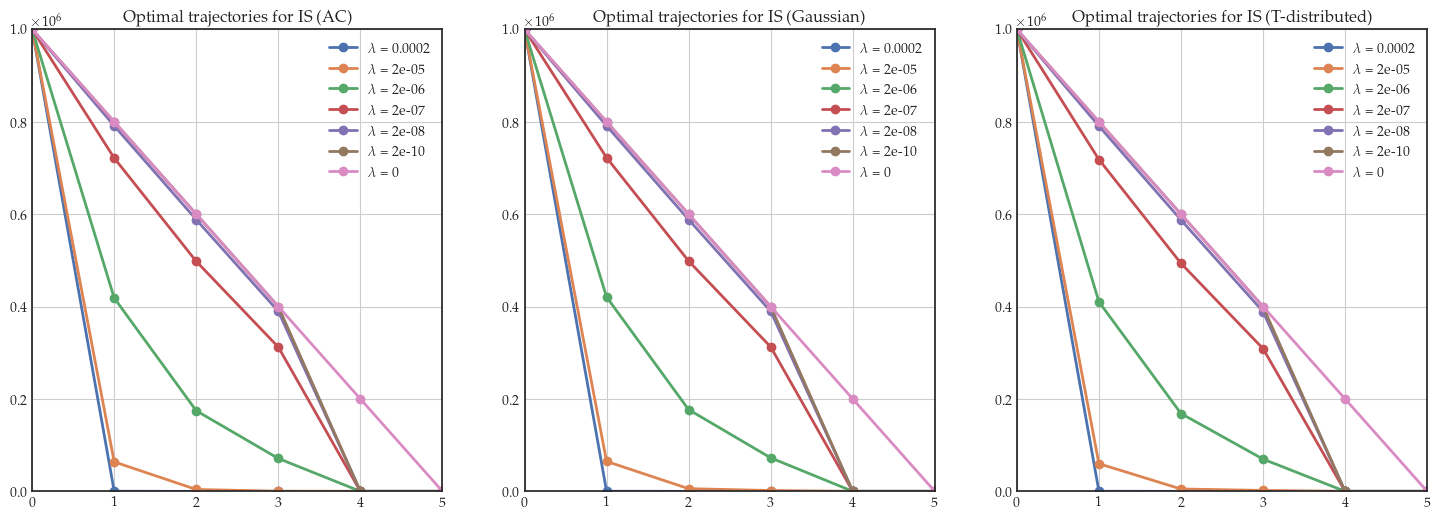

In [86]:
# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6), dpi=100, sharex=True)

# Figure 1
ax1.plot(np.append(path_test[0][3], 0), marker='o', lw=2.0, label=r'$\lambda$ = ' + str(risk_tol_values[3]))
ax1.plot(np.append(path_test[0][4], 0), marker='o', lw=2.0, label=r'$\lambda$ = ' + str(risk_tol_values[4]))
ax1.plot(np.append(path_test[0][5], 0), marker='o', lw=2.0, label=r'$\lambda$ = ' + str(risk_tol_values[5]))
ax1.plot(np.append(path_test[0][6], 0), marker='o', lw=2.0, label=r'$\lambda$ = ' + str(risk_tol_values[6]))
ax1.plot(np.append(path_test[0][7], 0), marker='o', lw=2.0, label=r'$\lambda$ = ' + str(risk_tol_values[7]))
ax1.plot(np.append(path_test[0][8], 0), marker='o', lw=2.0, label=r'$\lambda$ = ' + str(risk_tol_values[8]))
ax1.plot(path_test[0][9], marker='o', lw=2.0, label=r'$\lambda$ = ' + str(risk_tol_values[9]))
ax1.set_ylim([0, 1e6])
ax1.grid(True)
ax1.set_title('Optimal trajectories for IS (AC)')
ax1.legend(loc='best')


# Figure 2
ax2.plot(np.append(path_test[1][3], 0), marker='o', lw=2.0, label=r'$\lambda$ = ' + str(risk_tol_values[3]))
ax2.plot(np.append(path_test[1][4], 0), marker='o', lw=2.0, label=r'$\lambda$ = ' + str(risk_tol_values[4]))
ax2.plot(np.append(path_test[1][5], 0), marker='o', lw=2.0, label=r'$\lambda$ = ' + str(risk_tol_values[5]))
ax2.plot(np.append(path_test[1][6], 0), marker='o', lw=2.0, label=r'$\lambda$ = ' + str(risk_tol_values[6]))
ax2.plot(np.append(path_test[1][7], 0), marker='o', lw=2.0, label=r'$\lambda$ = ' + str(risk_tol_values[7]))
ax2.plot(np.append(path_test[1][8], 0), marker='o', lw=2.0, label=r'$\lambda$ = ' + str(risk_tol_values[8]))
ax2.plot(path_test[1][9], marker='o', lw=2.0, label=r'$\lambda$ = ' + str(risk_tol_values[9]))
ax2.set_ylim([0, 1e6])
ax2.grid(True)
ax2.set_title('Optimal trajectories for IS (Gaussian)')
ax2.legend(loc='best')
# Figure 3
ax3.plot(np.append(path_test[2][3], 0), marker='o', lw=2.0, label=r'$\lambda$ = ' + str(risk_tol_values[3]))
ax3.plot(np.append(path_test[2][4], 0), marker='o', lw=2.0, label=r'$\lambda$ = ' + str(risk_tol_values[4]))
ax3.plot(np.append(path_test[2][5], 0), marker='o', lw=2.0, label=r'$\lambda$ = ' + str(risk_tol_values[5]))
ax3.plot(np.append(path_test[2][6], 0), marker='o', lw=2.0, label=r'$\lambda$ = ' + str(risk_tol_values[6]))
ax3.plot(np.append(path_test[2][7], 0), marker='o', lw=2.0, label=r'$\lambda$ = ' + str(risk_tol_values[7]))
ax3.plot(np.append(path_test[2][8], 0), marker='o', lw=2.0, label=r'$\lambda$ = ' + str(risk_tol_values[8]))
ax3.plot(path_test[2][9], marker='o', lw=2.0, label=r'$\lambda$ = ' + str(risk_tol_values[9]))
ax3.set_ylim([0, 1e6])
ax3.set_xlim([0,5])
ax3.grid(True)
ax3.set_title('Optimal trajectories for IS (T-distributed)')
ax3.legend(loc='best')
# Save the combined figures
plt.savefig('liquidation_IS_combined.png')
plt.show()


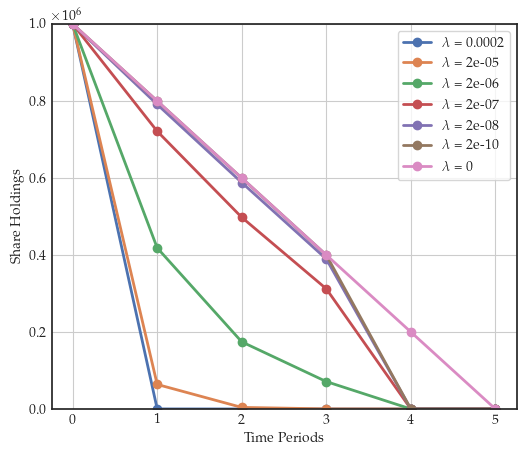

In [90]:
plt.figure(figsize=(6,5), dpi=100)
# Figure 1
plt.plot(np.append(path_test[0][3], 0), marker='o', lw=2.0, label=r'$\lambda$ = ' + str(risk_tol_values[3]))
plt.plot(np.append(path_test[0][4], 0), marker='o', lw=2.0, label=r'$\lambda$ = ' + str(risk_tol_values[4]))
plt.plot(np.append(path_test[0][5], 0), marker='o', lw=2.0, label=r'$\lambda$ = ' + str(risk_tol_values[5]))
plt.plot(np.append(path_test[0][6], 0), marker='o', lw=2.0, label=r'$\lambda$ = ' + str(risk_tol_values[6]))
plt.plot(np.append(path_test[0][7], 0), marker='o', lw=2.0, label=r'$\lambda$ = ' + str(risk_tol_values[7]))
plt.plot(np.append(path_test[0][8], 0), marker='o', lw=2.0, label=r'$\lambda$ = ' + str(risk_tol_values[8]))
plt.plot(path_test[0][9], marker='o', lw=2.0, label=r'$\lambda$ = ' + str(risk_tol_values[9]))
plt.ylim([0, 1e6])
plt.grid(True)
plt.xlabel(r'Time Periods')
plt.ylabel(r'Share Holdings')
#plt.title('Optimal trajectories for IS (AC)')
plt.savefig('liqudation_AC_analytical.pdf')
plt.legend(loc='best',frameon=True)

In [77]:
print(path_test[0][3])
print(path_test[0][4])

[1.00000000e+06 1.65636488e+02 2.74354691e-02 4.56720591e-06
 2.36323103e-08 2.29338184e-08 2.29338184e-08 2.29338184e-08
 2.29338184e-08 2.29338184e-08 2.29338184e-08 2.29338184e-08
 2.29338184e-08 2.29338184e-08 2.29338184e-08 2.29338184e-08
 2.29338184e-08 2.29338184e-08 2.29338184e-08 2.29338184e-08
 2.29338184e-08 2.29338184e-08 2.29338184e-08 2.29338184e-08
 2.29338184e-08 2.29338184e-08 2.29338184e-08 2.29338184e-08
 2.29338184e-08 2.29338184e-08 2.29338184e-08 2.29338184e-08
 2.29338184e-08 2.29338184e-08 2.29338184e-08 2.29338184e-08
 2.29338184e-08 2.29338184e-08 2.29338184e-08 2.29338184e-08
 2.29338184e-08 2.29338184e-08 2.29338184e-08 2.29338184e-08
 2.29338184e-08 2.29338184e-08 2.29338184e-08 2.29338184e-08
 2.29338184e-08 2.29338184e-08 2.29338184e-08 2.29338184e-08
 2.29338184e-08 2.29338184e-08 2.29338184e-08 2.29338184e-08
 2.29338184e-08 2.29338184e-08 2.29338184e-08 0.00000000e+00]
[ 1.00000000e+06  6.37370785e+04  4.06241517e+03  2.58926474e+02
  1.65032170e+01  1

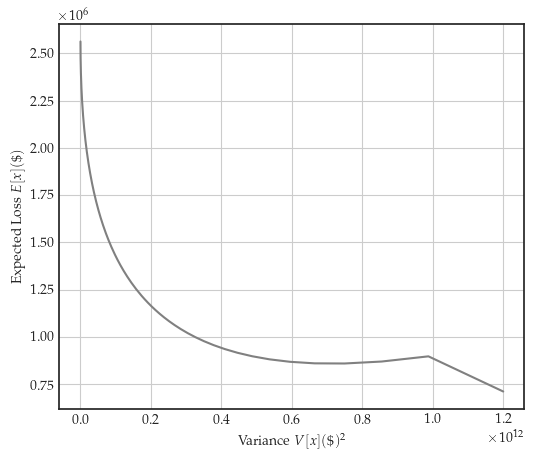

In [91]:
### Efficient Frontier (Analytical)

risk_tol_values = np.linspace(2*10**(-4), 0, 2000)
expectation_list = []
variance_list = []
color_list = []

for i in range(len(risk_tol_values)):
    expectation_baseline = is_expected(trading_traj_2(trading_time=trading_time, tau=tau, risk_tol=risk_tol_values[i], sigma=sigma,
                              gamma=gamma, eta=eta, X=X), gamma, eta, eps, tau)
    #print(expectation_baseline)
    var_baseline = is_var(trading_traj_2(trading_time=trading_time, tau=tau, risk_tol=risk_tol_values[i], sigma=sigma,
                              gamma=gamma, eta=eta, X=X)[1:], 0.3 / np.sqrt(250) * s_0, tau)
    
    expectation_list.append(expectation_baseline)
    variance_list.append(var_baseline)
    color_list.append(i) 

# Plotting with color coding
plt.figure(figsize=(6,5), dpi=100)
#plt.scatter(variance_list, expectation_list, c=color_list, cmap='Greys')
plt.plot(variance_list,expectation_list, color='gray')
plt.xlabel('Variance'  +r' $V[x] (\$)^2$')
plt.ylabel('Expected Loss' +r' $E[x] (\$)$')
#plt.title('Expectation vs Variance (Color-coded)')
#plt.colorbar(label='Risk_tol_value')
plt.savefig('analytical_ef.pdf')
plt.grid(True)
#plt.ylim(500000,2600000)
plt.show()

In [ ]:
print(risk_tol_values)

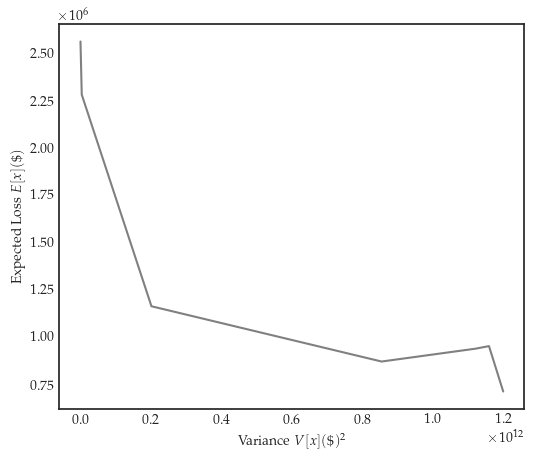

In [92]:
#risk_tol_values = np.linspace(2*10**(-4), 0, 2000)
risk_tol_values = [2*10**(-4),2*10**(-5),2*10**(-6),2*10**(-7),2*10**(-8),2*10**(-10),0]
expectation_list = []
variance_list = []
color_list = []

for i in range(len(risk_tol_values)):
    expectation_baseline = is_expected(trading_traj_2(trading_time=trading_time, tau=tau, risk_tol=risk_tol_values[i], sigma=sigma,
                              gamma=gamma, eta=eta, X=X), gamma, eta, eps, tau)
    #print(expectation_baseline)
    var_baseline = is_var(trading_traj_2(trading_time=trading_time, tau=tau, risk_tol=risk_tol_values[i], sigma=sigma,
                              gamma=gamma, eta=eta, X=X)[1:], 0.3 / np.sqrt(250) * s_0, tau)
    
    expectation_list.append(expectation_baseline)
    variance_list.append(var_baseline)
    color_list.append(i) 

# Plotting with color coding
plt.figure(figsize=(6,5), dpi=100)
#plt.scatter(variance_list, expectation_list, c=color_list, cmap='Greys')
plt.plot(variance_list,expectation_list, color='gray')
plt.xlabel('Variance'  +r' $V[x] (\$)^2$')
plt.ylabel('Expected Loss' +r' $E[x] (\$)$')
#plt.title('Expectation vs Variance (Color-coded)')
#plt.colorbar(label='Risk_tol_value')
plt.savefig('analytical_ef.pdf')
#plt.ylim(500000,2600000)
plt.show()

In [114]:
print(expectation_list)
print(variance_list)

print(is_expected(trading_traj_2(trading_time=trading_time, tau=tau, risk_tol=2*10**(-7), sigma=sigma,
                              gamma=gamma, eta=eta, X=X)[0:3], gamma, eta, eps, tau))

print(is_expected(trading_traj_2(trading_time=trading_time, tau=tau, risk_tol=2*10**(-8), sigma=sigma,
                              gamma=gamma, eta=eta, X=X)[0:3], gamma, eta, eps, tau))

[2561827.3997658244, 2280827.171067828, 1162855.2865829996, 870832.4734066857, 938858.124180583, 952355.5014114046, 712500.0]
[18713.50047273852, 3611871674.999185, 201481253264.23734, 854795128603.2401, 1121674924249.3105, 1159605868014.1475, 1200000000000.9]
521042.79836918873
410383.536322301


In [ ]:
### Efficient Frontier for DP

import pickle

# Load dp_p1_list
with open('dp_p1_list.pkl', 'rb') as f:
    dp_p1_list = pickle.load(f)

# Load dp_p1_list
with open('dp_p2_list.pkl', 'rb') as f:
    dp_p2_list = pickle.load(f)



In [ ]:
### Creating the Efficient frontier for DP

#traj_dp = np.concatenate(dp_p1_list) ## long list
traj_dp = np.concatenate(dp_p2_list) ## short list

expectation_baseline = []
var_baseline = []

for traj in traj_dp:
    expectation = is_expected(traj, gamma, eta, eps, tau)
    variance = is_var(traj, 0.3/np.sqrt(250)*s_0, tau)
    expectation_baseline.append(expectation)
    var_baseline.append(variance)

print(expectation_baseline)
print(var_baseline)

# Plotting with color coding
plt.figure(figsize=(6,5), dpi=100)
#plt.scatter(var_baseline, expectation_baseline, c=color_list, cmap='Greys')
plt.plot(var_baseline,expectation_baseline, color='gray')
plt.xlabel('Variance'  +r' $V[x] (\$)^2$')
plt.ylabel('Expected Loss' +r' $E[x] (\$)$')
#plt.title('Expectation vs Variance (Color-coded)')
#plt.colorbar(label='Risk_tol_value')
plt.grid(True)
#plt.savefig('analytical_ef.pdf')
#plt.ylim(500000,2600000)
plt.show()

In [115]:
print(traj_dp)

NameError: name 'traj_dp' is not defined

In [ ]:
#print(traj_dp)
#n = np.array(expectation_list)
#d = np.array(expectation_baseline)
#factor = d/n
#print(np.round(factor*np.array(expectation_list)/1e6,5))
#print(np.round(factor*np.array(variance_list)/1e12,5))
#print(np.array(var_baseline)/1e8)
(50*1e6 - 2.12007 * 1e6) / np.sqrt(0.00673 * 1e12)
(50*1e6 - 2.13713 * 1e6) /np.sqrt(0.00376*1e12)


In [ ]:
### Expectation and variance for lambda = 2*10**(-6) (Gaussian)
gauss_mu, gauss_sigma = 0, 1
trading_time = 5
X = 1e6

expectations = []

for _ in range(100000):
    gauss_s = np.random.normal(gauss_mu, gauss_sigma, trading_time)/100
    gauss_innovation = 1 + gauss_s
    _s0_gauss = 50 * np.cumprod(gauss_innovation)
    _s0_gauss = np.append(50, _s0_gauss)
    traj_test_6 = trading_traj_2(trading_time=trading_time, tau=tau, risk_tol=risk_tol_values[5], sigma=_sigma_gauss[:4], gamma=gamma, eta=eta, X=X)
    expectation_gauss = X * 50 - np.sum(_s0_gauss[:4] * traj_test_6[:4])
    expectations.append(expectation_gauss)

# Print the first 10 estimated expectations
print(expectations[:10])
print(np.mean(expectations))
print(np.std(expectations))

In [ ]:
plt.hist(expectations)

In [ ]:
### Expectation and variance for lambda =  2*10**(-5) (Gaussian)
gauss_mu, gauss_sigma = 0, 1
trading_time = 5
X = 1e6

expectations = []

for _ in range(100000):
    gauss_s = np.random.normal(gauss_mu, gauss_sigma, trading_time)/100
    gauss_innovation = 1 + gauss_s
    _s0_gauss = 50 * np.cumprod(gauss_innovation)
    _s0_gauss = np.append(50, _s0_gauss)
    traj_test_5= trading_traj_2(trading_time=trading_time, tau=tau, risk_tol=risk_tol_5, sigma=_sigma_gauss[:4], gamma=gamma, eta=eta, X=X)
    expectation_gauss = X * 50 - np.sum(_s0_gauss[:4] * traj_test_5[:4])
    expectations.append(expectation_gauss)

# Print the first 10 estimated expectations
print(expectations[:10])
print(np.mean(expectations))
print(np.std(expectations))

In [ ]:
### Expectation and variance for lambda = 0 (Gaussian)
gauss_mu, gauss_sigma = 0, 1
trading_time = 5
X = 1e6

expectations = []
var = []
std = []

for _ in range(1000):
    gauss_s = np.random.normal(gauss_mu, gauss_sigma, trading_time)/100
    gauss_innovation = 1 + gauss_s
    _s0_gauss = 50 * np.cumprod(gauss_innovation)
    _s0_gauss = np.append(50, _s0_gauss)
    traj_test_10= trading_traj_2(trading_time=trading_time, tau=tau, risk_tol=risk_tol_values[9], sigma=_sigma_gauss[:4], gamma=gamma, eta=eta, X=X)
    expectation_gauss = X * 50 - np.sum(_s0_gauss[:5] * traj_test_10[:5])
    var_gauss = np.var(_s0_gauss[:5] * traj_test_10[:5])
    std_gauss = np.std(_s0_gauss[:5] * traj_test_10[:5])
    expectations.append(expectation_gauss)
    var.append(var_gauss)
    std.append(std_gauss)

# Print the first 10 estimated expectations
print(expectations[:10])
print(var[:10])
print(std[:10])

In [ ]:
plt.hist(expectations)

In [ ]:
# Generate values between 1 and 100
x = np.linspace(1, 100, 100)

# Calculate np.sinh() for each value
y = np.sinh(x)

# Plot the evolution of np.sinh()
plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('sinh(x)')
#plt.title('Evolution of sinh(x) for values between 1 and 100')
plt.grid(True)
plt.show()
